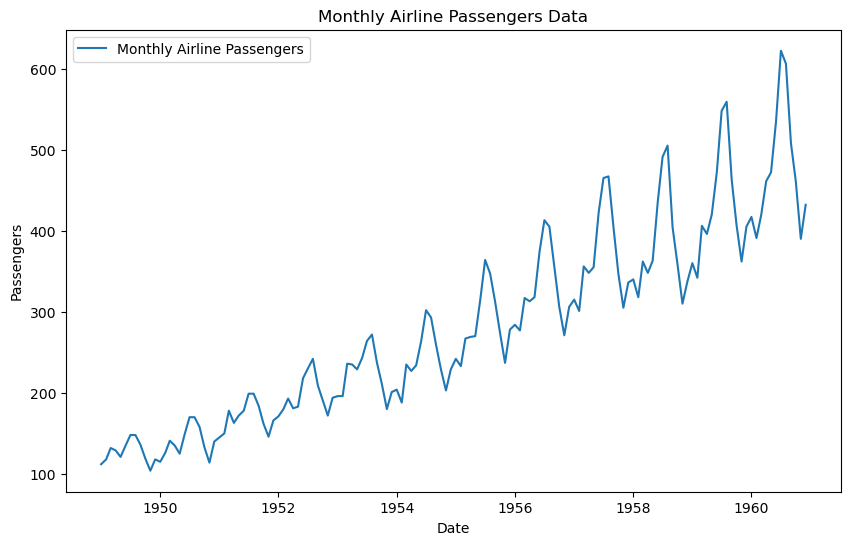

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, index_col='Month', parse_dates=True)
series = data['Passengers']

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(series, label='Monthly Airline Passengers')
plt.title('Monthly Airline Passengers Data')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()


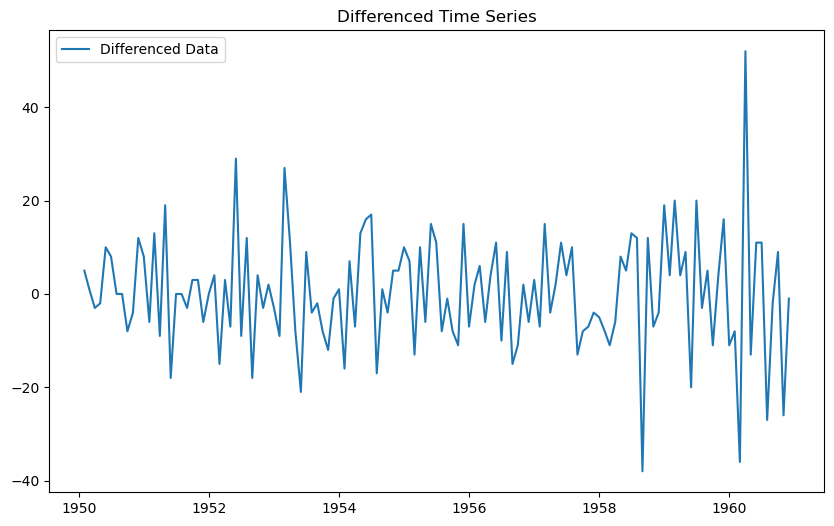

ADF Statistic: -15.59561808374634
p-value: 1.856511600123444e-28


In [3]:
# Seasonal differencing with a lag of 12 for annual seasonality
series_diff = series.diff(12).dropna()

# First differencing for stationarity after seasonal differencing
series_diff = series_diff.diff().dropna()

# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(series_diff, label='Differenced Data')
plt.title('Differenced Time Series')
plt.legend()
plt.show()

# Check stationarity with ADF test
result = adfuller(series_diff)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


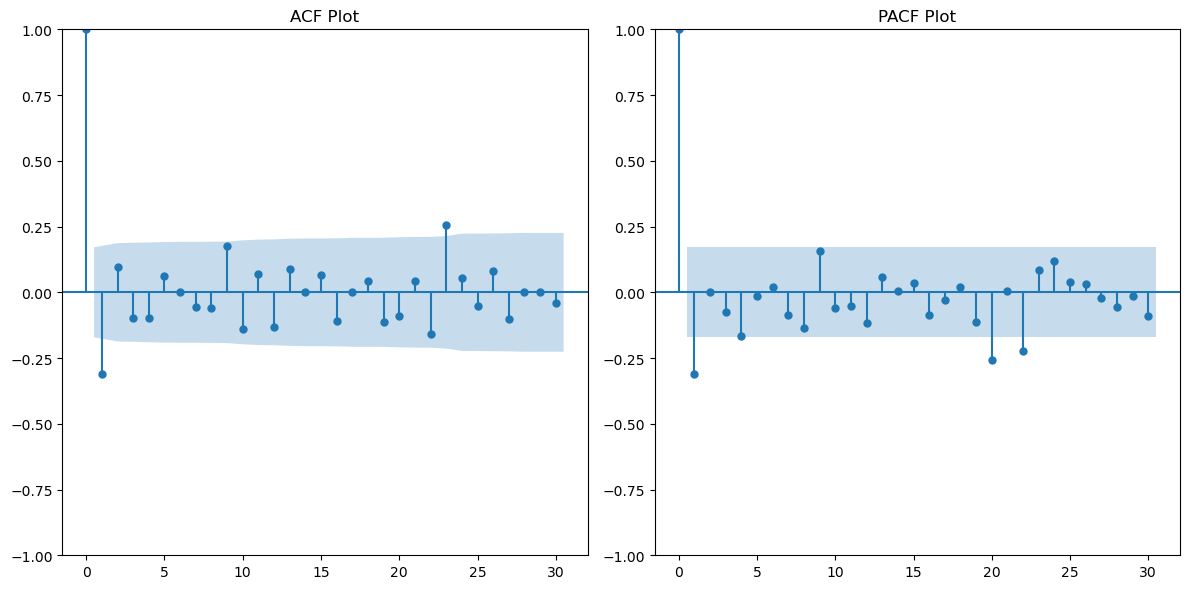

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(series_diff, ax=plt.gca(), lags=30)
plt.title('ACF Plot')

plt.subplot(1, 2, 2)
plot_pacf(series_diff, ax=plt.gca(), lags=30)
plt.title('PACF Plot')

plt.tight_layout()
plt.show()


C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.149
Date:                            Fri, 08 Nov 2024   AIC                           1022.299
Time:                                    21:26:50   BIC                           1036.675
Sample:                                01-01-1949   HQIC                          1028.140
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1272      0.356     -0.358      0.721      -0.825       0.570
ma.L1         -0.2148      0.325   

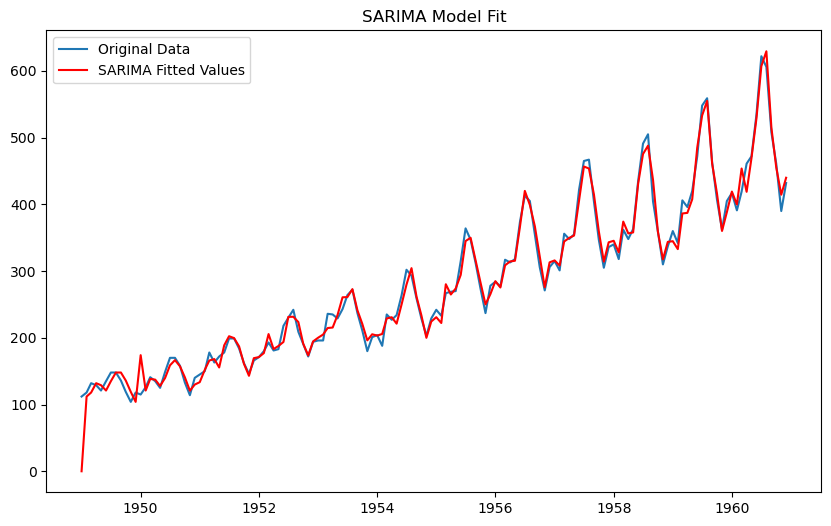

In [5]:
# Define the SARIMA model
model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Summary of the model
print(model_fit.summary())

# Plot the fitted values
plt.figure(figsize=(10, 6))
plt.plot(series, label='Original Data')
plt.plot(model_fit.fittedvalues, color='red', label='SARIMA Fitted Values')
plt.title('SARIMA Model Fit')
plt.legend()
plt.show()


In [6]:
from sklearn.model_selection import TimeSeriesSplit

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
tscv_rmse, tscv_mae = [], []

for train_index, test_index in tscv.split(series):
    train, test = series.iloc[train_index], series.iloc[test_index]
    
    # Fit SARIMA model on training data
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    
    # Forecast for test set length
    predictions = model_fit.forecast(steps=len(test))
    
    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    mae = mean_absolute_error(test, predictions)
    tscv_rmse.append(rmse)
    tscv_mae.append(mae)

print(f'TimeSeriesSplit - Average RMSE: {np.mean(tscv_rmse)}, Average MAE: {np.mean(tscv_mae)}')


C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_m

TimeSeriesSplit - Average RMSE: 33.94090630614145, Average MAE: 29.98579454133021
